In [1]:
# IMPORT
import numpy as np
import wandb
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import shutil
import os                              # Import the 'os' module for changing directories
os.chdir('/content/drive/MyDrive/FL')  # Change the directory

Mounted at /content/drive


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import Subset, DataLoader, random_split

from FederatedLearningProject.data.cifar100_loader import get_cifar100, create_iid_splits, create_non_iid_splits
import FederatedLearningProject.checkpoints.checkpointing as checkpointing
from FederatedLearningProject.training.FedMETA import aggregate_with_task_arithmetic, aggregate_masks_by_sparsity, aggregate_masks, distribution_function, train_server
from FederatedLearningProject.training.model_editing import plot_all_layers_mask_sparsity

from FederatedLearningProject.experiments import models
import copy

In [3]:
import importlib

# Importa i moduli del tuo progetto
from FederatedLearningProject.data import cifar100_loader
from FederatedLearningProject import checkpoints
from FederatedLearningProject.training import FedMETA, model_editing
from FederatedLearningProject import experiments

# Ricarica solo i moduli custom (NO torch)
importlib.reload(cifar100_loader)
importlib.reload(checkpoints.checkpointing)
importlib.reload(FedMETA)
importlib.reload(model_editing)
importlib.reload(experiments.models)


# Re-bind: importa di nuovo funzioni/classi/alias che usi nel codice
from FederatedLearningProject.data.cifar100_loader import (
    get_cifar100, create_iid_splits, create_non_iid_splits
)

import FederatedLearningProject.checkpoints.checkpointing as checkpointing

from FederatedLearningProject.training.FedMETA import (
    aggregate_with_task_arithmetic,
    aggregate_masks,
    distribution_function,
    train_server
)

from FederatedLearningProject.training.model_editing import (
    plot_all_layers_mask_sparsity
)

from FederatedLearningProject.experiments import models


In [4]:
wandb.login() # Ask for your APIw key for logging in to the wandb library.

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: depetrofabio (depetrofabio-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
device = "cuda"
model_name = "dino_vits16_J4"
project_name = "FederatedProject"

# Generate a unique run name for each iteration
run_name = f"{model_name}_rounds"
# INITIALIZE W&B for each new run
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "model": model_name,
        "num_rounds": 1, # Use the current num_rounds_val
        "batch_size": 128, # Using test_loader's batch_size as a placeholder
    },
    reinit=True # Important: Allows re-initialization of wandb in a loop
)

# Copy your config
config = wandb.config

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [5]:
# print the content of the folder FederatedLearningProject.data.masks
print(os.listdir('FederatedLearningProject/masks'))

val_set = torch.load('FederatedLearningProject/masks/val_set.pth', weights_only=False)
train_set = torch.load('FederatedLearningProject/masks/train_set.pth', weights_only=False)
test_set = torch.load('FederatedLearningProject/masks/test_set.pth', weights_only=False)

['train_set.pth', 'val_set.pth', 'test_set.pth', 'client_masks_iid.pth', 'client_masks_non_iid_1.pth', 'client_masks_non_iid_5.pth', 'client_masks_non_iid_10.pth', 'client_masks_non_iid_50.pth', 'light_weight_masks_non_iid_1.pth', 'PORCODDIO.pth', 'light_weight_masks_iid.pth', 'light_weight_masks_non_iid_5.pth', 'light_weight_masks_non_iid_10.pth', 'light_weight_masks_non_iid_50.pth', 'client_masks_iid_sparsity_08.pth', 'client_masks_non_iid_1_sparsity_08.pth', 'masks_non_iid_1_07.pth', 'client_masks_non_iid_1_sparsity_07.pth', 'masks_non_iid_1_095.pth', 'light_masks_iid_1_sparsity_095.pth']


In [13]:
o_model = models.LinearFlexibleDino(num_layers_to_freeze=12)
#local_masks = torch.load('FederatedLearningProject/masks/client_masks_non_iid_1.pth')
local_masks = torch.load('FederatedLearningProject/masks/light_weight_masks_iid.pth')


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


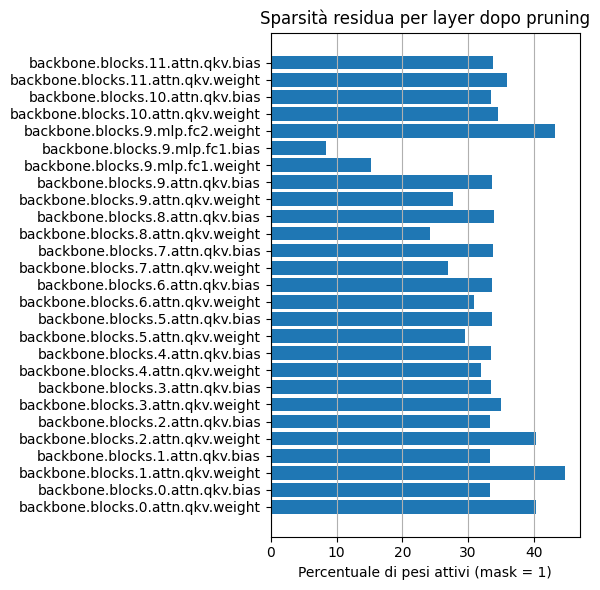

In [14]:
plot_all_layers_mask_sparsity(local_masks[0])

In [ ]:
#o_model = models.LinearFlexibleDino(num_layers_to_freeze=12)
#local_masks = torch.load('FederatedLearningProject/masks/light_weight_masks_non_iid_1.pth')

In [15]:
model = copy.deepcopy(o_model)
model_checkpoint = torch.load("FederatedLearningProject/checkpoints/FL_IID_300round/dino_vits_16_iid_local_steps_4_checkpoint.pth")
#model_checkpoint = torch.load("FederatedLearningProject/checkpoints/FL_NON_IID(1)/dino_vits_16_non_iid(1)_local_steps_4_checkpoint.pth")

In [16]:
model.load_state_dict(model_checkpoint['model_state_dict'])
#model.debug()

<All keys matched successfully>

In [17]:
model.unfreeze(12)
#model.debug()

In [18]:
final_mask = aggregate_masks_by_sparsity(local_masks, sparsity_target = 0.9)
del local_masks

Sparsity Target: 0.90 -> Keeping 2129356/21293568 params.
Calculated Threshold (min votes to be kept): 51
Achieved Sparsity: 0.8995


In [19]:
partition_masks = distribution_function(final_mask, number_clients=100)

Total parameters: 21293568
Masked parameters (zeros): 19153091
Unmasked parameters (ones): 2140477


In [21]:
client_dataset = create_iid_splits(train_set, num_clients=100)    # each client will see only 1 class
#client_dataset = create_non_iid_splits(train_set, num_clients=100, classes_per_client=1)    # each client will see only 1 class

Dataset has 40000 samples across 100 classes.
Creating 100 IID splits with 100 classes each.


Each of the 100 classes split into 100 shards.

Checking unique classes that each client sees:
Client 0 has samples from classes: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), 

In [ ]:
optimizer_config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0.0001
}

model.to_cuda()

checkpoint_path = 'FederatedLearningProject/checkpoints/'
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)
criterion = nn.CrossEntropyLoss()

res = train_server(model, num_rounds=1, frac=1, num_client_steps = 80, client_dataset=client_dataset, client_masks=partition_masks, optimizer_config=optimizer_config, device='cuda', batch_size=128, val_loader=val_loader, checkpoint_path=checkpoint_path, criterion=criterion)

In [ ]:
res["client_accuracies"]

In [24]:
from FederatedLearningProject.training.FedMETA import val
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)
x = val(res["model"], test_loader, criterion=criterion, device='cuda')
print(x[1])

7.63
